# Age Estimation and Gender Classification


## Setting Up: Mount the google drive
Mount your google drive to the notebook.

Also don't forget to **enable GPU** before your training.


In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import PIL
from keras.models import Model
from keras.preprocessing.image import load_img, ImageDataGenerator
from keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Visualize a few photos
It is always benificial to know your data well before you start. Here display a few (at least 20) images together with its corresponding age and gender from the `train_val/` folder to have a first impression of the dataset. You may also check what the size of the images are.

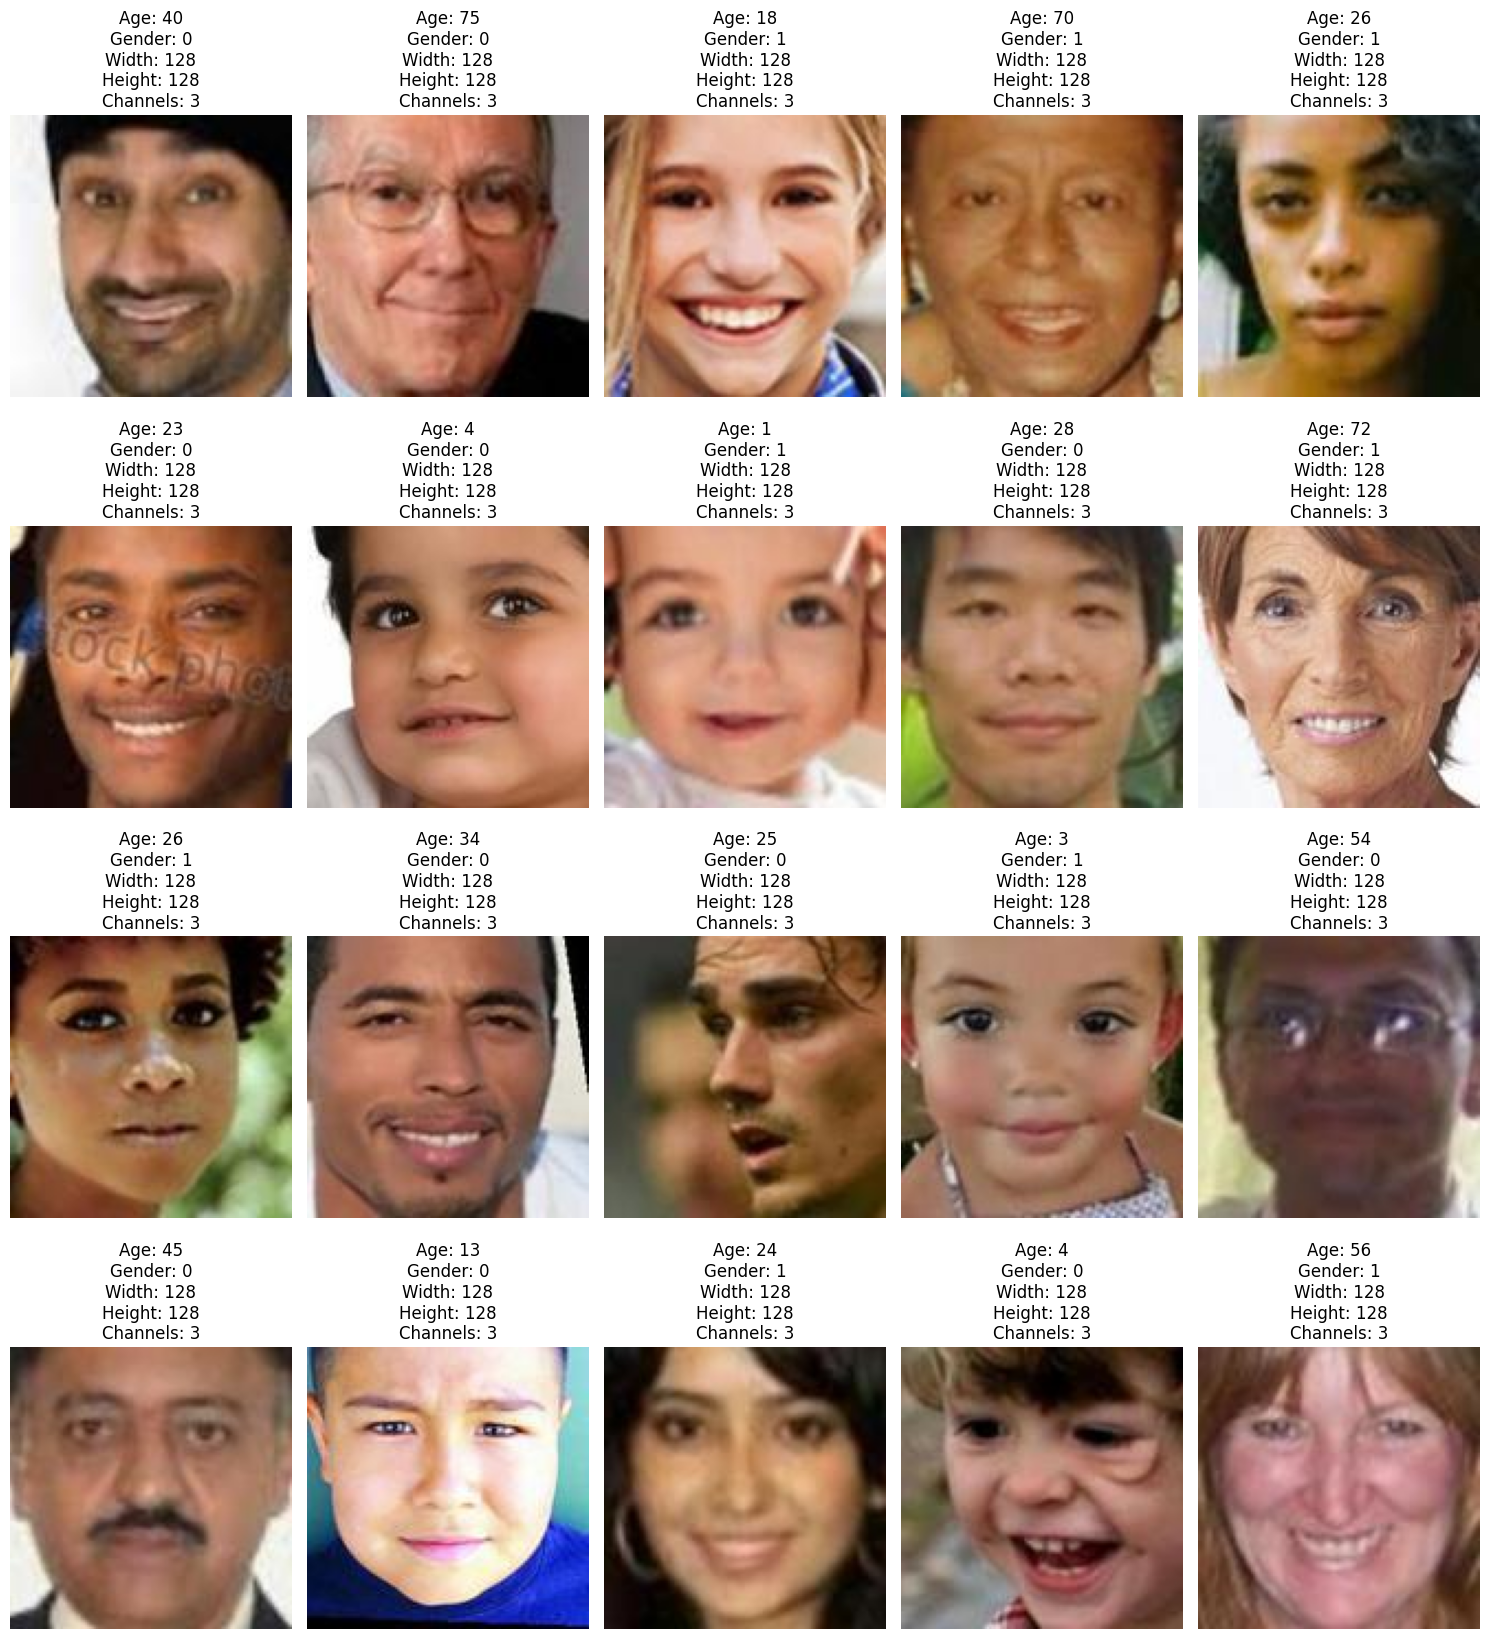

In [ ]:
dataset_path = '/content/drive/MyDrive/train_val/'
# dataset_path = 'train_val/'

# Get the list of files in the dataset folder
file_list = os.listdir(dataset_path)


num_images_to_display = 20

# Increase the size of the figure
plt.figure(figsize=(15, 17))

for i in range(num_images_to_display):
    # Get the image file
    image_file = file_list[i]

    # Get the corresponding age and gender information from the filename
    age, gender = image_file.split('_')[:2]

    # Load and display the image
    image_path = os.path.join(dataset_path, image_file)
    img = Image.open(image_path)

    # Get image size (width, height) and number of channels
    width, height = img.size
    channels = len(img.getbands())

    # Display image with title (age and gender)
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title(f'Age: {age}\nGender: {gender}\nWidth: {width}\nHeight: {height}\nChannels: {channels}')
    plt.axis('off')


# Adjust layout and display the images
plt.tight_layout()
plt.show()

## Rearrange the dataset
You may do any arrangement for the dataset to suit your later process, such as splitting into training set and validation set, saving the gender labels and age some how, and so on.


In [ ]:
path = Path(dataset_path)
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))

np.random.seed(42)
np.random.shuffle(filenames)

age_labels, gender_labels, image_path = [], [], []
for filename in filenames:
    image_path.append(filename.strip())
    temp = filename.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])

data = pd.DataFrame()
data['image'], data['age'], data['gender'] = image_path, age_labels, gender_labels
data['path'] = [path / img_path for img_path in image_path]

gender_dict = {0:"Male",1:"Female"}
data = data.astype({'age':'float32', 'gender': 'int32', 'path' : 'str'})

train, test = train_test_split(data, test_size=0.2, random_state=42)

## STEP1: Data pre-processing
Now you need do some pre-processing before feeding data into a CNN network. You may consider:

1.	Rescale the pixel values (integers between 0 and 255) to [0,1]. **You must do this rescaling.** Otherwise the testing performance will be affected significantly, as the test images will be rescaling in this way.
2.	Data augmentation.

**Don't rescale the age to [0,1].** Otherwise the testing performance will be affected significantly, as the original age is used in the testing stage.

In [ ]:
# Create an ImageDataGenerator for data augmentation if needed
datagen_train = ImageDataGenerator(rescale=1./255,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True,
                            fill_mode='nearest')

batch_size = 32
train_dataset = datagen_train.flow_from_dataframe(
    dataframe=train,
    directory=None,
    x_col = 'path',
    y_col = ['gender', 'age'],
    batch_size=batch_size,
    target_size=(128, 128),
    class_mode='multi_output',
    validate_filenames=False)

# Create a separate ImageDataGenerator for validation with rescaling
datagen_validate = ImageDataGenerator(rescale=1./255)

validate_dataset = datagen_validate.flow_from_dataframe(
    dataframe=test,
    directory=None,
    x_col = 'path',
    y_col = ['gender', 'age'],
    batch_size=batch_size,
    target_size=(128, 128),
    class_mode='multi_output',
    validate_filenames=False)


Found 4000 non-validated image filenames.
Found 1000 non-validated image filenames.


## STEP2A: Build your own CNN network

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 126, 126, 32)         896       ['input_image[0][0]']         
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 63, 63, 32)           128       ['max_pooling2d[0][0]']   

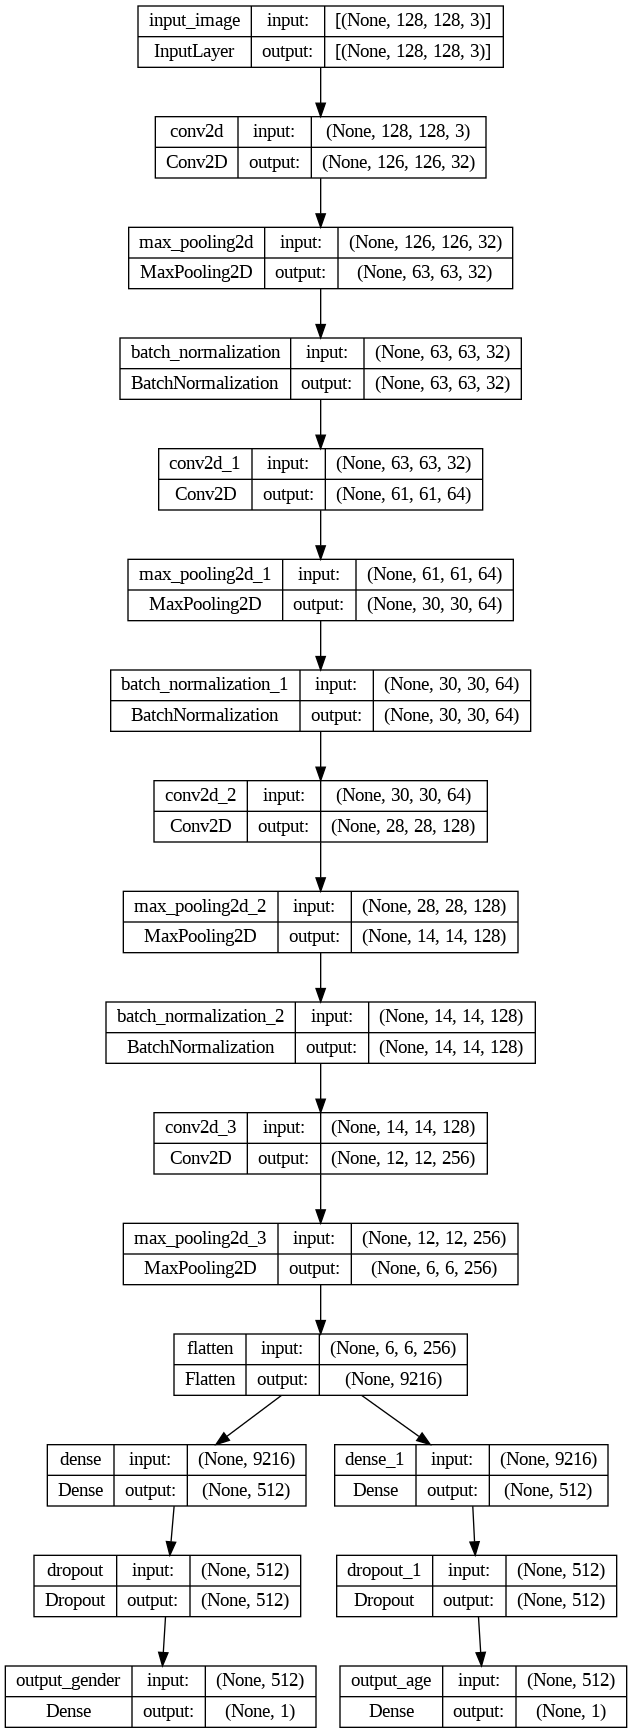

In [ ]:

input_shape = (128, 128, 3)
input_layer = Input(shape=input_shape, name='input_image')

conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_layer)
conv1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv1 = BatchNormalization()(conv1)


conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(conv1)
# conv2 = Dropout(0.1)(conv2)
conv2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv2 = BatchNormalization()(conv2)


conv3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(conv2)
# conv3 = Dropout(0.1)(conv3)
conv3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv3 = BatchNormalization()(conv3)


conv4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(conv3)
conv4 = MaxPooling2D(pool_size=(2, 2))(conv4)

flatten = Flatten()(conv4)


# Fully connected layers for gender classification
dense_gender = Dense(512, activation='relu')(flatten)
dense_gender = Dropout(0.3)(dense_gender)
output_gender = Dense(1, activation='sigmoid', name='output_gender')(dense_gender)


# Fully connected layers for age classification
dense_age = Dense(512, activation='relu')(flatten)
dense_age = Dropout(0.3)(dense_age)
output_age = Dense(1, activation='linear', name='output_age')(dense_age)



modelA = Model(inputs=input_layer, outputs=[output_gender, output_age])

modelA.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelA, show_shapes=True)

## STEP3A: Compile and train your model


In [ ]:
# your_model_folder='models/'
your_model_folder='/content/drive/MyDrive/models/'

callback_opt = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=5, restore_best_weights=True)


# Adjust the optimizer
optimizer = Adam(learning_rate=0.001)

modelA.compile(
    loss={
        'output_gender': 'binary_crossentropy',
        'output_age': 'mae'},
    optimizer=optimizer,
    metrics={'output_gender': 'accuracy',
             'output_age': 'mae'})


history = modelA.fit(train_dataset, epochs=100, callbacks=callback_opt, validation_data=validate_dataset)

modelA.save(your_model_folder+"age_gender_A.h5")

Epoch 1/100
125/125 [==============================] - 85s 287ms/step - loss: 16.4213 - output_gender_loss: 1.0162 - output_age_loss: 15.4051 - output_gender_accuracy: 0.6255 - output_age_mae: 15.4051 - val_loss: 14.8992 - val_output_gender_loss: 0.6761 - val_output_age_loss: 14.2231 - val_output_gender_accuracy: 0.5440 - val_output_age_mae: 14.2231
Epoch 2/100
125/125 [==============================] - 35s 281ms/step - loss: 13.8820 - output_gender_loss: 0.5925 - output_age_loss: 13.2895 - output_gender_accuracy: 0.6840 - output_age_mae: 13.2895 - val_loss: 20.1954 - val_output_gender_loss: 0.6920 - val_output_age_loss: 19.5034 - val_output_gender_accuracy: 0.5480 - val_output_age_mae: 19.5034
Epoch 3/100
125/125 [==============================] - 33s 265ms/step - loss: 13.1180 - output_gender_loss: 0.5610 - output_age_loss: 12.5571 - output_gender_accuracy: 0.7132 - output_age_mae: 12.5571 - val_loss: 13.1535 - val_output_gender_loss: 0.5679 - val_output_age_loss: 12.5856 - val_outpu

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## STEP4A: Draw the learning curves
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set


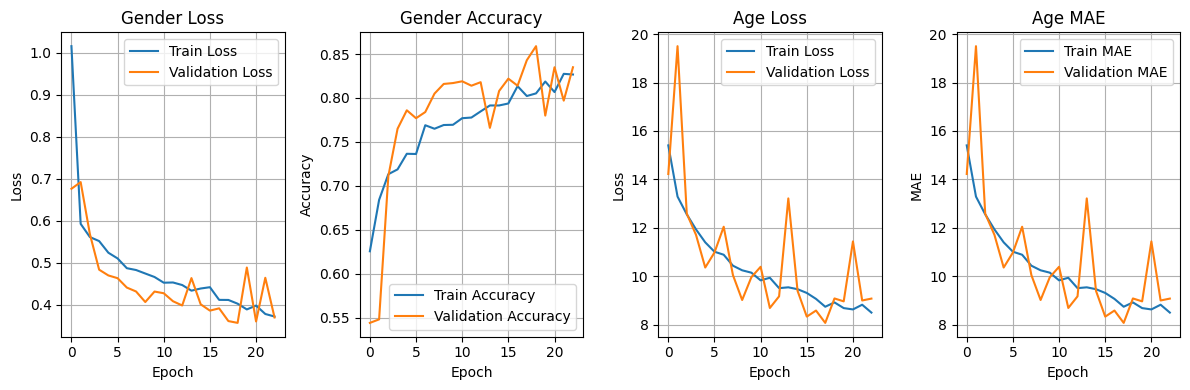

In [ ]:
# Plotting training loss for gender
plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1)
plt.plot(history.history['output_gender_loss'], label='Train Loss')
plt.plot(history.history['val_output_gender_loss'], label='Validation Loss')
plt.title('Gender Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plotting training accuracy for gender
plt.subplot(1, 4, 2)
plt.plot(history.history['output_gender_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_output_gender_accuracy'], label='Validation Accuracy')
plt.title('Gender Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Plotting training loss for age
plt.subplot(1, 4, 3)
plt.plot(history.history['output_age_loss'], label='Train Loss')
plt.plot(history.history['val_output_age_loss'], label='Validation Loss')
plt.title('Age Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plotting training MAE for age
plt.subplot(1, 4, 4)
plt.plot(history.history['output_age_mae'], label='Train MAE')
plt.plot(history.history['val_output_age_mae'], label='Validation MAE')
plt.title('Age MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## STEP2B: Build a CNN network based on a pre-trained model


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, 4, 4, 512)            1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 flatten_1 (Flatten)         (None, 8192)                 0         ['vgg16[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 512)                  4194816   ['flatten_1[0][0]']     

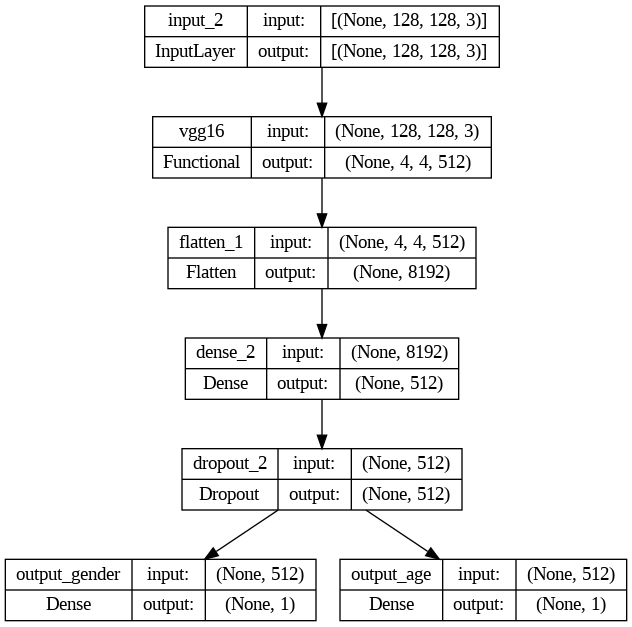

In [ ]:
# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the convolutional layers of the pre-trained model
for layer in base_model.layers[:14]:
    layer.trainable = False

# Build the top layers for classification
input_layer = Input(shape=(128, 128, 3))
vgg_output = base_model(input_layer)
# x = BatchNormalization()(vgg_output)
flatten = Flatten()(vgg_output)
x = Dense(512, activation='relu')(flatten)
x = Dropout(0.3)(x)

# Add a dense layer for gender classification
# dense_gender = Dense(128, activation='relu')(flatten)
gender_output = Dense(1, activation='sigmoid', name='output_gender')(x)

# Add a dense layer for age regression
# dense_age = Dense(128, activation='relu')(flatten)
age_output = Dense(1, activation='linear', name='output_age')(x)

modelB = Model(inputs=input_layer, outputs=[gender_output, age_output])

modelB.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelB, show_shapes=True)

## STEP3B: Compile and train your model


In [ ]:
your_model_folder='/content/drive/MyDrive/models/'

optimizer = Adam(learning_rate=0.001)
callback_opt = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=5, restore_best_weights=True)

modelB.compile(
    loss={
        'output_gender': 'binary_crossentropy',
        'output_age': 'mae'},
    optimizer=optimizer,
    metrics={'output_gender': 'accuracy',
             'output_age': 'mae'})

historyB = modelB.fit(train_dataset, epochs=100, callbacks=callback_opt, validation_data=validate_dataset)

modelB.save(your_model_folder+"age_gender_B.h5")

Epoch 1/100
125/125 [==============================] - 42s 293ms/step - loss: 14.2519 - output_gender_loss: 1.0227 - output_age_loss: 13.2292 - output_gender_accuracy: 0.5558 - output_age_mae: 13.2292 - val_loss: 10.5938 - val_output_gender_loss: 0.6371 - val_output_age_loss: 9.9567 - val_output_gender_accuracy: 0.6660 - val_output_age_mae: 9.9567
Epoch 2/100
125/125 [==============================] - 36s 284ms/step - loss: 9.5620 - output_gender_loss: 0.7077 - output_age_loss: 8.8543 - output_gender_accuracy: 0.6442 - output_age_mae: 8.8543 - val_loss: 9.6305 - val_output_gender_loss: 0.5709 - val_output_age_loss: 9.0596 - val_output_gender_accuracy: 0.7120 - val_output_age_mae: 9.0596
Epoch 3/100
125/125 [==============================] - 36s 286ms/step - loss: 8.7569 - output_gender_loss: 0.6461 - output_age_loss: 8.1108 - output_gender_accuracy: 0.6715 - output_age_mae: 8.1108 - val_loss: 8.4650 - val_output_gender_loss: 0.6284 - val_output_age_loss: 7.8366 - val_output_gender_accu

## STEP4B: Draw the learning curve
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

In [ ]:
# Plotting training loss for gender
plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1)
plt.plot(historyB.history['output_gender_loss'], label='Train Loss')
plt.plot(historyB.history['val_output_gender_loss'], label='Validation Loss')
plt.title('Gender Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plotting training accuracy for gender
plt.subplot(1, 4, 2)
plt.plot(historyB.history['output_gender_accuracy'], label='Train Accuracy')
plt.plot(historyB.history['val_output_gender_accuracy'], label='Validation Accuracy')
plt.title('Gender Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Plotting training loss for age
plt.subplot(1, 4, 3)
plt.plot(historyB.history['output_age_loss'], label='Train Loss')
plt.plot(historyB.history['val_output_age_loss'], label='Validation Loss')
plt.title('Age Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plotting training MAE for age
plt.subplot(1, 4, 4)
plt.plot(historyB.history['output_age_mae'], label='Train MAE')
plt.plot(historyB.history['val_output_age_mae'], label='Validation MAE')
plt.title('Age MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()